In [1]:
!python --version
import sys
sys.executable

Python 2.7.6


'/usr/bin/python2'

In [2]:
from math import sqrt
import os
import glob

from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import lstm2
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.


### This notebook shows how we train a small number of stocks to predict the next 30 day price

# 1. Use stock data only

In [3]:
source_dir='../data/sp500_test'
nlp_dir = None #'../data/nlp_by_company'
revenue_dir = None
# Please make sure these 3 dirs exist 
models_dir = '../models/sp500_test/'
supervised_data_dir = '../data/sup_sp500_test'
prediction_data_dir = '../data/prediction/sp500_test'

rmse_csv = '../data/rsme_ltsm.csv'
# look back n days. Note: The hight n_lags is, the more overfitting it becomes 
# because there are more features added with the fix number of data we currently have.
# When we add more features later, we may have to cut down n_lags even more
n_lags = 5 
n_forecast = 30 
n_test = 90 # test = last 90 days from data
'''
config_file = '../config/lstm2.config'
source_dir, models_dir, supervised_data_dir, prediction_data_dir, rmse_csv,n_lags, n_forecast, n_test = lstm2.read_config(config_file)
'''
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir, 
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)
n_features

MSFT
../data/sp500_test/MSFT.csv has 4493 rows
              Volume  Adj Close
Date                           
2000-01-03  53228400  38.903194
2000-01-04  54119000  37.589046
2000-01-05  64059600  37.985374
2000-01-06  54976600  36.712940
2000-01-07  62013600  37.192707
(4459, 12)
('Generating', '../data/sup_sp500_test/MSFT_supervised.csv')
NDAQ
../data/sp500_test/NDAQ.csv has 3869 rows
            Volume  Adj Close
Date                         
2002-07-01    1300  13.694478
2002-07-02    7000  13.813163
2002-07-03   10200  13.694478
2002-07-05     500  13.694478
2002-07-08     300  12.781513
(3835, 12)
('Generating', '../data/sup_sp500_test/NDAQ_supervised.csv')
O
../data/sp500_test/O.csv has 4493 rows
            Volume  Adj Close
Date                         
2000-01-03   98800   3.604251
2000-01-04  119800   3.560825
2000-01-05   96400   3.539115
2000-01-06   64600   3.582541
2000-01-07  137600   3.647675
(4459, 12)
('Generating', '../data/sup_sp500_test/O_supervised.csv')
ORCL
../

2

Data for Q


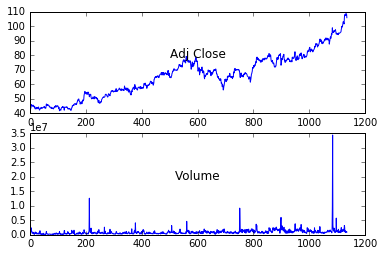

Data for ORCL


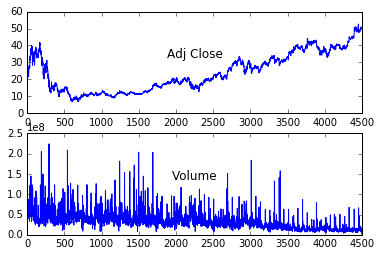

Data for NDAQ


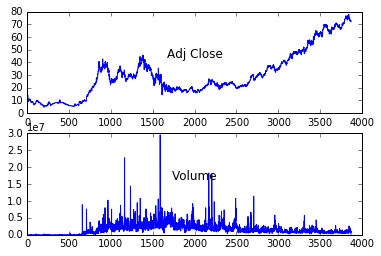

Data for O


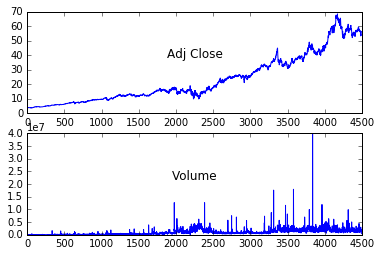

Data for MSFT


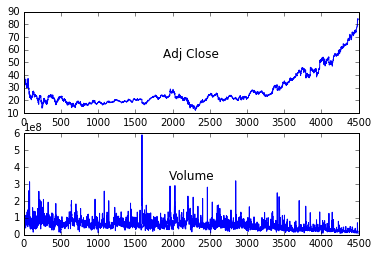

In [4]:
def view_dataframe(df):
    dataset = df
    values = dataset.values
    # Revised order of columns
    groups = np.array(range(len(list(dataset))-1, -1, -1)) #[0, 1, 2, 3, 5] #, 6, 7
    #groups = np.array(range(len(list(dataset)))) #[0, 1, 2, 3, 5] #, 6, 7
    # specify columns to plot
    i = 1
    # plot each column
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group]) #,ax=ax)
        pyplot.title(dataset.columns[group], y=0.5) #, loc='left')
        i += 1
    pyplot.show()

for stock in orig_dfs.keys():
    pyplot.figure(figsize=(6,4))
    print('Data for ' + stock)
    view_dataframe(orig_dfs[stock])

#view_dataframe(orig_dfs['MSFT'])

# Multiple lag timesteps

In [5]:
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features, 100)

('Processing', 'MSFT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 11s - loss: 0.0290 - val_loss: 0.0206
Epoch 2/30
4369/4369 [==============================] - 11s - loss: 0.0270 - val_loss: 0.0203
Epoch 3/30
4369/4369 [==============================] - 11s - loss: 0.0262 - val_loss: 0.0221
Epoch 4/30
4369/4369 [==============================] - 10s - loss: 0.0261 - val_loss: 0.0374
Epoch 5/30
4369/4369 [==============================] - 10s - loss: 0.0258 - val_loss: 0.0795
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
0.0795134067535
('Saving model to', '../models/sp500_test/MSFT.h5')
('Processing', 'NDAQ')
Train on 3745 samples, validate on 90 samples
Epoch 1/30
3745/3745 [==============================] - 9s - loss: 0.0387 - val_loss: 0.0759
Epoch 2/30
3745/3745 [==============================] - 9s - loss: 0.0342 - val_loss: 0.0550
Epoch 3/30
3745/3745 [==============================] - 9

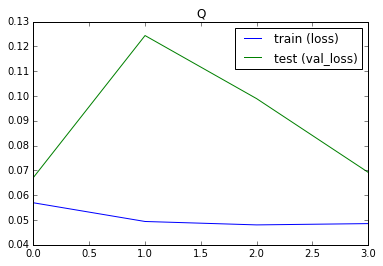

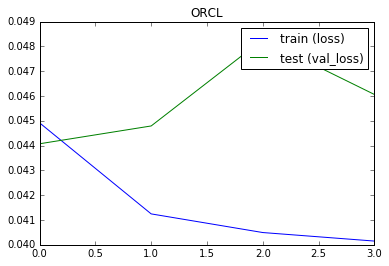

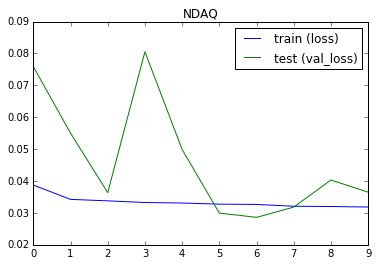

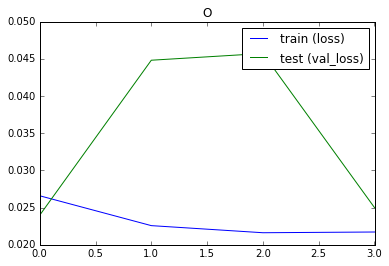

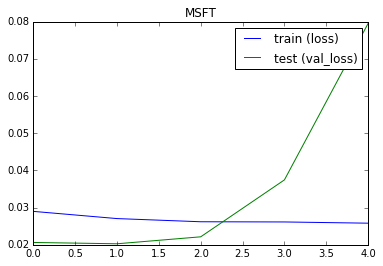

In [6]:
#print(histories)
for stock in histories.keys(): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

In [7]:
predicted_dfs, rmse_df = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)

../models/sp500_test/*.h5
('loading', '../models/sp500_test/MSFT.h5')
('Reading', '../data/sup_sp500_test/MSFT_supervised.csv')
Predicting...
Test RMSE: 6.096
('Writing to', '../data/prediction/sp500_test/MSFT_predicted.csv')
('loading', '../models/sp500_test/NDAQ.h5')
('Reading', '../data/sup_sp500_test/NDAQ_supervised.csv')
Predicting...
Test RMSE: 3.074
('Writing to', '../data/prediction/sp500_test/NDAQ_predicted.csv')
('loading', '../models/sp500_test/O.h5')
('Reading', '../data/sup_sp500_test/O_supervised.csv')
Predicting...
Test RMSE: 2.035
('Writing to', '../data/prediction/sp500_test/O_predicted.csv')
('loading', '../models/sp500_test/ORCL.h5')
('Reading', '../data/sup_sp500_test/ORCL_supervised.csv')
Predicting...
Test RMSE: 2.429
('Writing to', '../data/prediction/sp500_test/ORCL_predicted.csv')
('loading', '../models/sp500_test/Q.h5')
('Reading', '../data/sup_sp500_test/Q_supervised.csv')
Predicting...
Test RMSE: 5.704
('Writing to', '../data/prediction/sp500_test/Q_predicte

In [8]:
def plot_data(rmse_df, predicted_dfs):
    cnt = 1
    for index, row in rmse_df.iterrows():
        key = row['Stock Model']
        if (cnt % 2 != 0):
            fig, axes = plt.subplots(nrows=1, ncols=2)
            ax=axes[0]
        else:
            ax=axes[1]
        predicted_dfs[key].plot(title=key + ': n_forecast = ' + str(n_forecast) +
                                ', n_lags = ' + str(n_lags) + ': price vs days', 
                                figsize=(15,4), 
                                ax=ax)
        cnt += 1
    plt.show()

In [9]:
# default is sort by 'Avg predicted gain'
rmse_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,6.096134,0.117156,0.009204,0.121122,0.042196
3,ORCL,2.428930,0.026866,0.108223,0.014315,0.020995
4,Q,5.704205,0.013440,0.067273,0.003833,0.050988
2,O,2.035281,0.007092,0.027702,0.000084,0.006778
1,NDAQ,3.073763,0.000035,0.061155,-0.004483,0.023595


In [10]:
#rmse_df#.sort_values(by='Day 0 actual gain', ascending=False)

In [11]:
predicted_dfs2, summary_df = lstm2.read_prediction_files(prediction_data_dir)
# Should be exactly the same as rmse_df above
summary_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,6.096134,0.117156,0.009204,0.121122,0.042196
2,ORCL,2.428930,0.026866,0.108223,0.014315,0.020995
4,Q,5.704205,0.013440,0.067273,0.003833,0.050988
3,O,2.035281,0.007092,0.027702,0.000084,0.006778
1,NDAQ,3.073763,0.000035,0.061155,-0.004483,0.023595
5,USB,3.210445,-0.043120,0.029322,-0.038322,0.017449


In [12]:
# Compare 2 dataframes: They should be same
from pandas.util.testing import assert_frame_equal

#assert_frame_equal(rmse_df, summary_df)

for key in predicted_dfs.keys():
    print(key)
    assert_frame_equal(predicted_dfs[key], predicted_dfs2[key])

Q
ORCL
NDAQ
O
MSFT


# Visualize Results

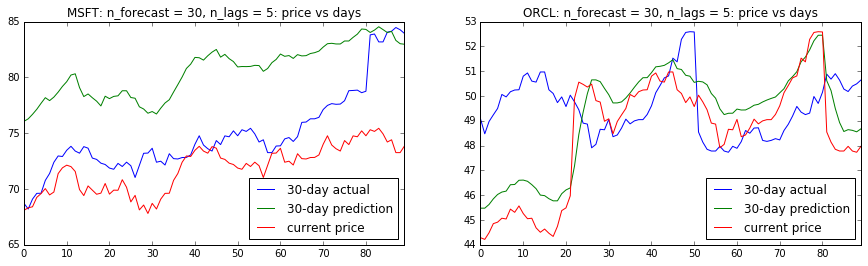

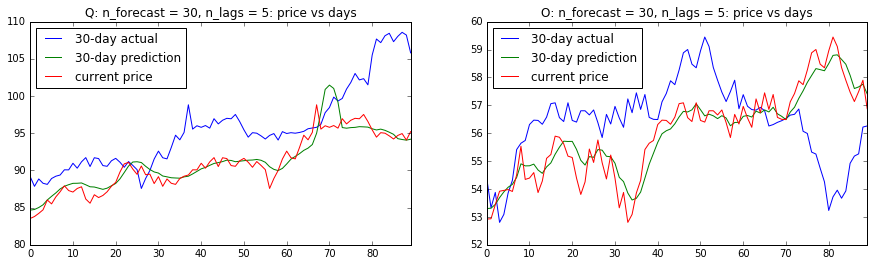

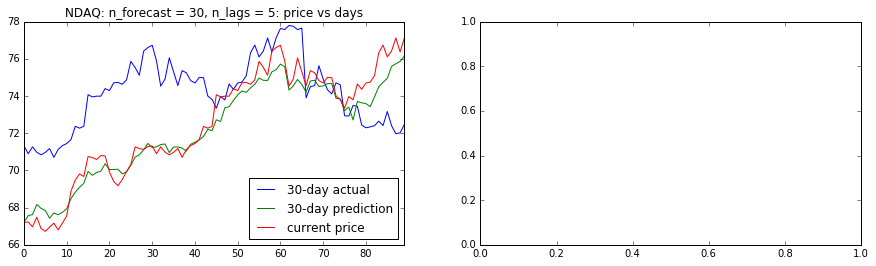

In [13]:
plot_data(rmse_df, predicted_dfs)

# 2. Use stock price, news and revenue data


In [14]:
n_lags = 5
nlp_dir = '../data/nlp_by_company'
revenue_dir = '../metadata/revenue'
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir,
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)

MSFT
../data/sp500_test/MSFT.csv has 4493 rows
              Volume  Adj Close
Date                           
2000-01-03  53228400  38.903194
2000-01-04  54119000  37.589046
2000-01-05  64059600  37.985374
2000-01-06  54976600  36.712940
2000-01-07  62013600  37.192707
('Reading', '../metadata/revenue/MSFT_Financials_by_Quarter.csv')
        year quarter  basiceps     netincome  totalrevenue
ticker                                                    
MSFT    2017      Q1      0.73  5.667000e+09  2.192800e+10
MSFT    2017      Q2      0.67  5.200000e+09  2.409000e+10
MSFT    2017      Q3      0.62  4.801000e+09  2.209000e+10
MSFT    2017      Q4      0.72  5.536000e+09  2.184200e+10
MSFT    2017      FY      2.74  2.120400e+10  8.995000e+10
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/MSFT.csv')
            buy  sell  positivity  subjectivity
date                                           
2015-10-22    0     0   -0.021212      0.451515
2015-11-04    0     0 

Q
../data/sp500_test/Q.csv has 1136 rows
              Volume  Adj Close
Date                           
2013-05-09  19153400  42.110001
2013-05-10   2969700  42.389999
2013-05-13   1053100  43.320000
2013-05-14   2049800  44.430000
2013-05-15   2380500  45.500000
('Reading', '../metadata/revenue/Q_Financials_by_Quarter.csv')
        year quarter  basiceps   netincome  totalrevenue
ticker                                                  
Q       2017      Q1      0.32  76000000.0  2.322000e+09
Q       2017      Q2      0.35  79000000.0  2.375000e+09
Q       2017      Q3      0.39  89000000.0  2.465000e+09
Q       2017      Q4      0.00         0.0  0.000000e+00
Q       2017      FY      0.00         0.0  0.000000e+00
('Process revenue data', 1136, 1136)
('Reading', '../data/nlp_by_company/Q.csv')
            buy  sell  positivity  subjectivity
date                                           
2015-10-28    0     0         0.0           0.0
2015-11-05    0     0         0.0           0.0


# Data Analysis

('Number of features:', 10)
Data for Q


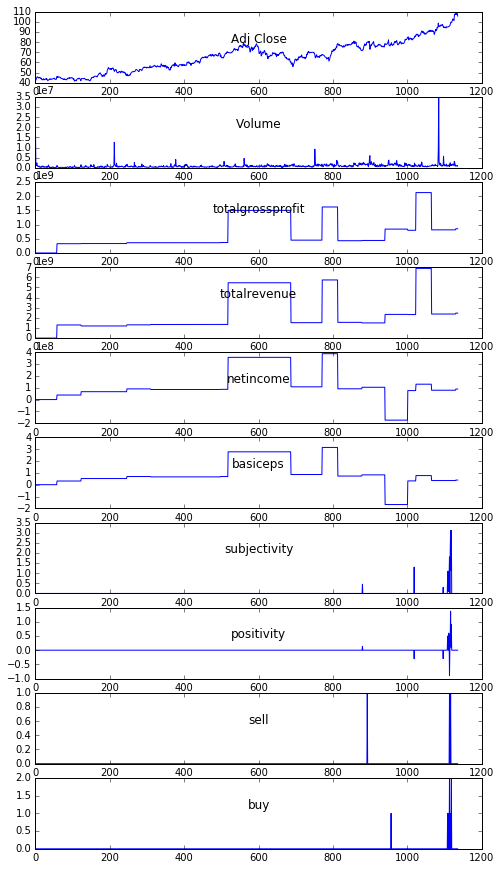

Data for ORCL


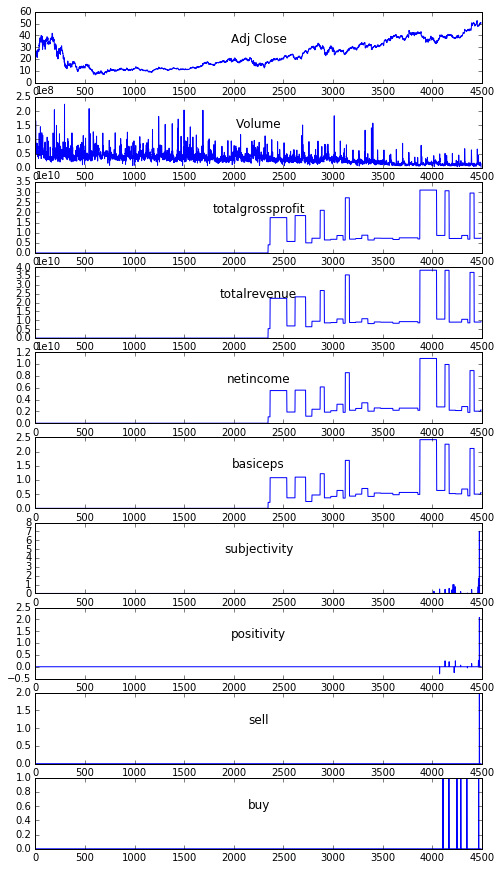

Data for NDAQ


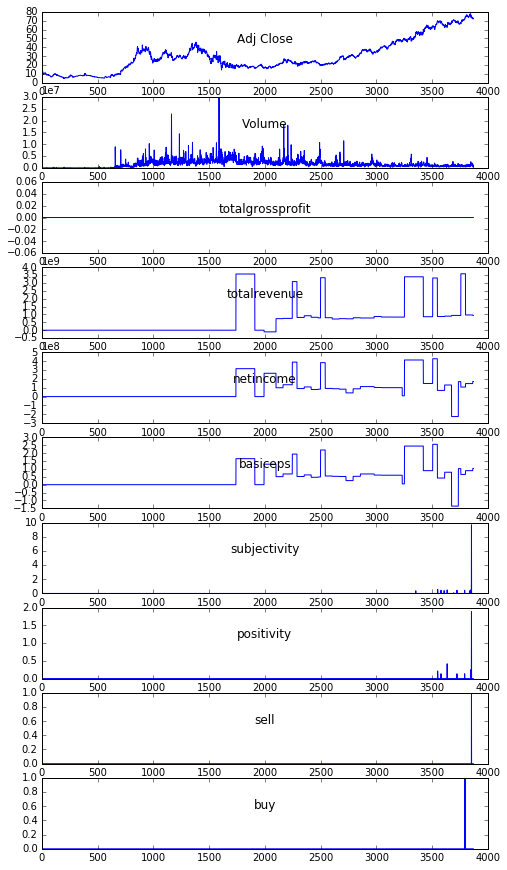

Data for O


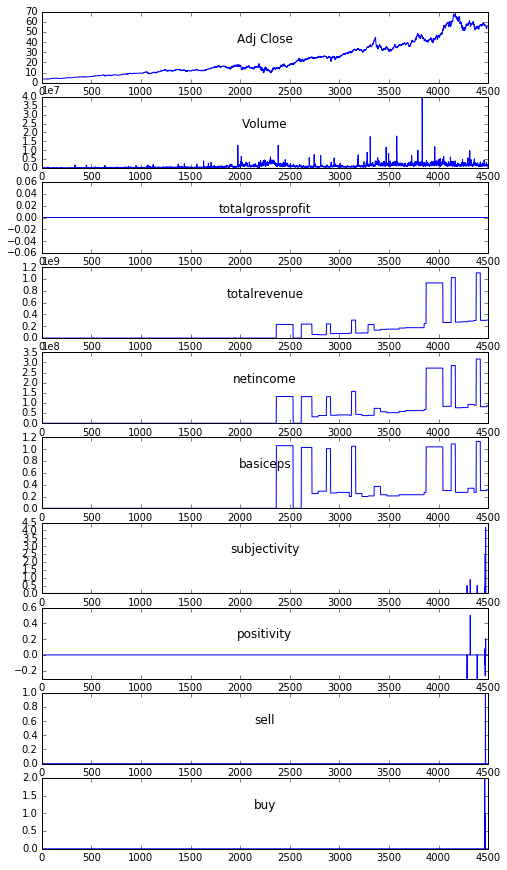

Data for MSFT


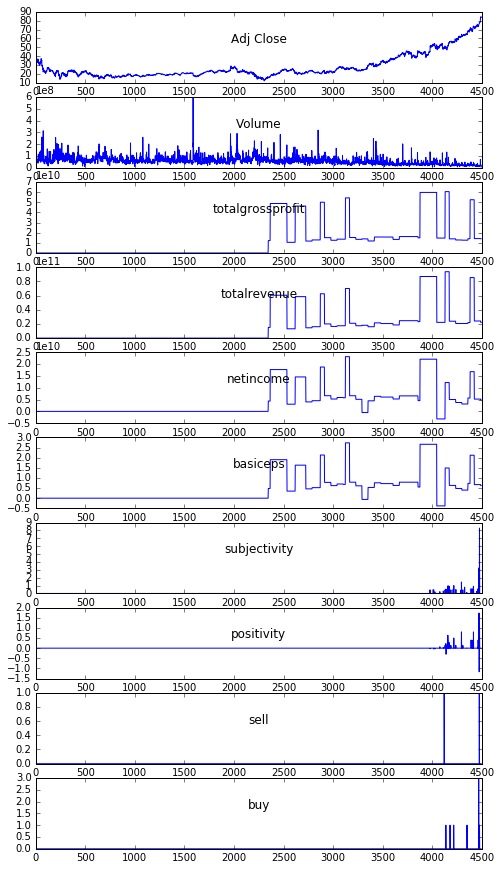

In [15]:
print('Number of features:', n_features)
for stock in orig_dfs.keys():
    pyplot.figure(figsize=(8,15))
#    print(orig_dfs[stock][['decline']].max())
    #print(orig_dfs[stock].positivity.unique())
    #print(orig_dfs[stock].subjectivity.unique())
    #.groupby().agg({'decline': ['min', 'max', 'unique'], 'sell': ['first', 'max', 'unique']})
    print('Data for ' + stock)
    view_dataframe(orig_dfs[stock])


Data for MSFT


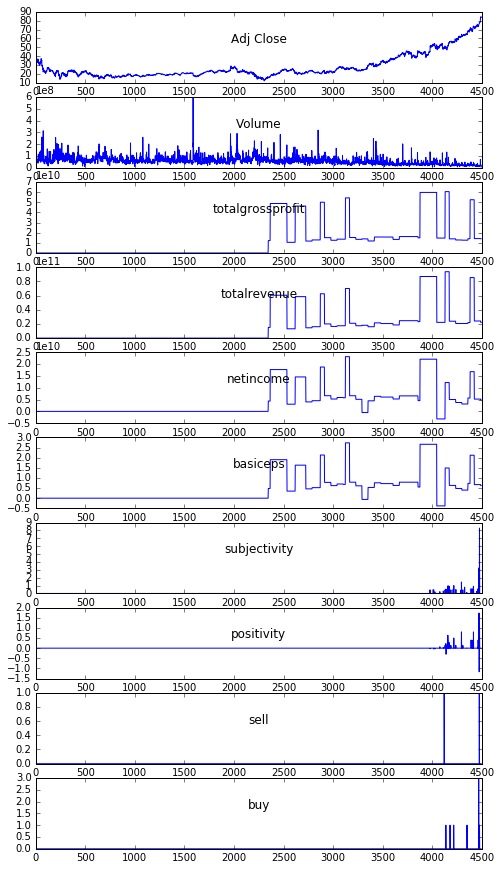

In [16]:
# Just look at 1 stock for simplicity
stock = 'MSFT'
print('Data for ' + stock)
pyplot.figure(figsize=(8,15))
view_dataframe(orig_dfs[stock])

* Stock data starts from 2000-01
* News data (subjectivity, positivity, decline, sell, buy, scandal) 
    + only available approximately for the past 500 days (ex: MSFT)
    + very sparsed
    + scandal, decline are consistently zero. Should we drop them?
    + buy, sell are sparsed, mostly 0s. Should we drop them?
* Revenue data () start from 2010?
    + operatingrevenue are 0s so we decided to drop them

## Create Models

('Processing', 'MSFT')
Train on 4369 samples, validate on 90 samples
Epoch 1/30
4369/4369 [==============================] - 63s - loss: 0.0339 - val_loss: 0.0373
Epoch 2/30
4369/4369 [==============================] - 63s - loss: 0.0281 - val_loss: 0.0684
Epoch 3/30
4369/4369 [==============================] - 63s - loss: 0.0265 - val_loss: 0.0500
Epoch 4/30
4369/4369 [==============================] - 63s - loss: 0.0261 - val_loss: 0.0289
Epoch 5/30
4369/4369 [==============================] - 63s - loss: 0.0252 - val_loss: 0.0428
Epoch 6/30
4369/4369 [==============================] - 63s - loss: 0.0249 - val_loss: 0.0869
Epoch 7/30
4369/4369 [==============================] - 63s - loss: 0.0245 - val_loss: 0.0348
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
0.0347821525402
('Saving model to', '../models/sp500_test/MSFT.h5')
('Processing', 'NDAQ')
Train on 3745 samples, validate on 90 samples
Epoch 1/30
3745/3745 [==============================] -

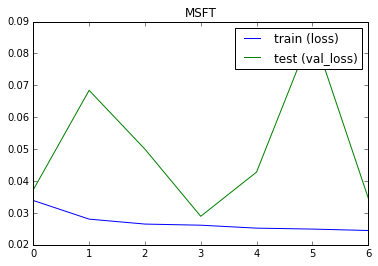

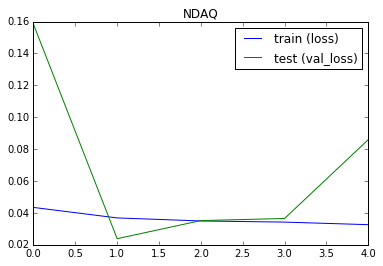

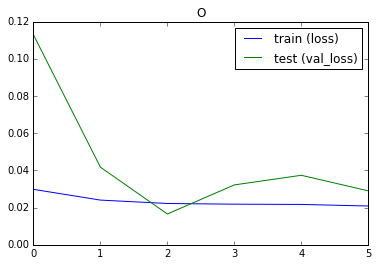

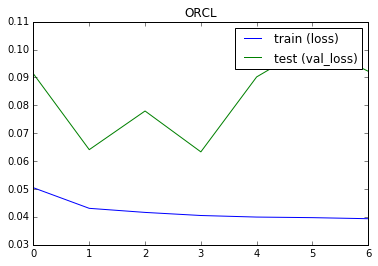

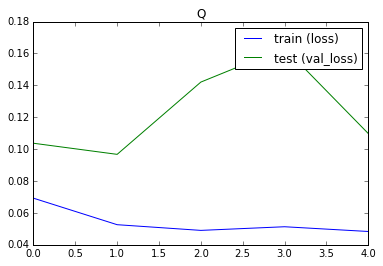

In [17]:
# With more features, increase n_neurons
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features, 
                               400)
#print(histories)
for stock in sorted(histories.keys()): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

## Make Predictions

In [18]:
predicted_dfs2, rmse_df2 = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)


../models/sp500_test/*.h5
('loading', '../models/sp500_test/MSFT.h5')
('Reading', '../data/sup_sp500_test/MSFT_supervised.csv')
Predicting...
Test RMSE: 3.351
('Writing to', '../data/prediction/sp500_test/MSFT_predicted.csv')
('loading', '../models/sp500_test/NDAQ.h5')
('Reading', '../data/sup_sp500_test/NDAQ_supervised.csv')
Predicting...
Test RMSE: 6.634
('Writing to', '../data/prediction/sp500_test/NDAQ_predicted.csv')
('loading', '../models/sp500_test/O.h5')
('Reading', '../data/sup_sp500_test/O_supervised.csv')
Predicting...
Test RMSE: 2.134
('Writing to', '../data/prediction/sp500_test/O_predicted.csv')
('loading', '../models/sp500_test/ORCL.h5')
('Reading', '../data/sup_sp500_test/ORCL_supervised.csv')
Predicting...
Test RMSE: 4.952
('Writing to', '../data/prediction/sp500_test/ORCL_predicted.csv')
('loading', '../models/sp500_test/Q.h5')
('Reading', '../data/sup_sp500_test/Q_supervised.csv')
Predicting...
Test RMSE: 8.316
('Writing to', '../data/prediction/sp500_test/Q_predicte

In [19]:
# check RMSE as risk indicators
rmse_df2

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,3.350991,0.015519,0.009204,0.008449,0.042196
2,O,2.133930,-0.012537,0.027702,-0.013073,0.006778
4,Q,8.316356,-0.002742,0.067273,-0.025767,0.050988
1,NDAQ,6.634007,-0.061582,0.061155,-0.062952,0.023595
3,ORCL,4.952261,-0.029843,0.108223,-0.066413,0.020995


In [20]:
# Compare to the previous one
rmse_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,6.096134,0.117156,0.009204,0.121122,0.042196
3,ORCL,2.428930,0.026866,0.108223,0.014315,0.020995
4,Q,5.704205,0.013440,0.067273,0.003833,0.050988
2,O,2.035281,0.007092,0.027702,0.000084,0.006778
1,NDAQ,3.073763,0.000035,0.061155,-0.004483,0.023595


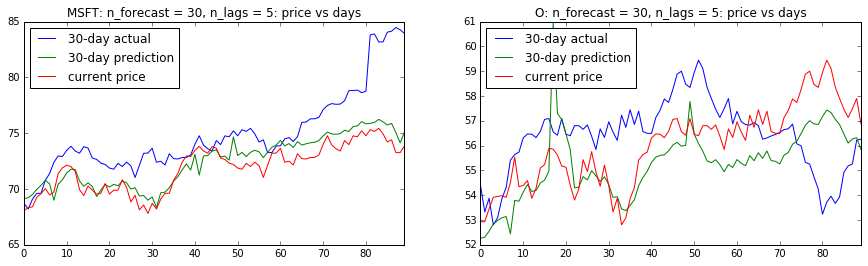

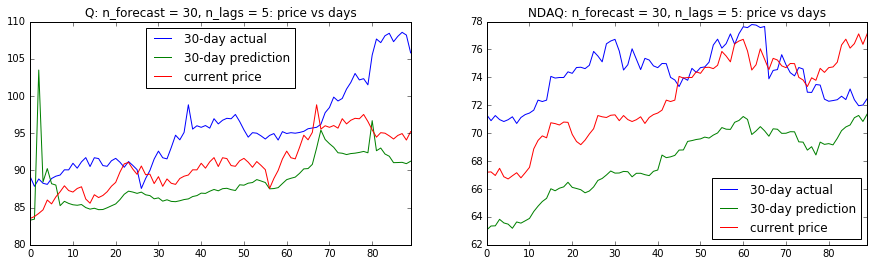

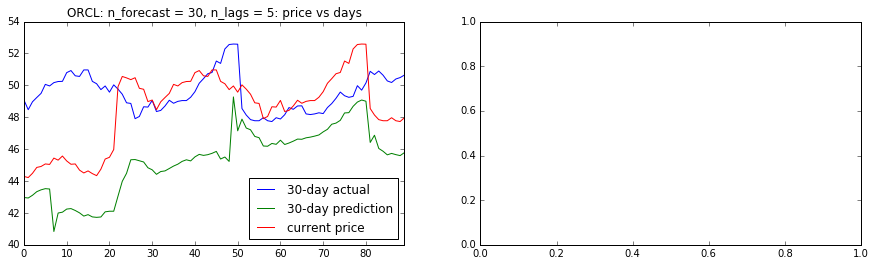

In [21]:
plot_data(rmse_df2, predicted_dfs2)

# Observations:

* This 2nd set of predictions with news and revenue data looks better than the first set

Let's try to decrease n_lags to see overfitting improves

## Decrease n_lags 

In [22]:
n_lags = 3 # look back 3 days
n_features, orig_dfs, datasets = lstm2.set_up_data(source_dir, 
                                                   nlp_dir, 
                                                   revenue_dir,
                                                   supervised_data_dir, 
                                                   n_lags, 
                                                   n_forecast)
n_features

MSFT
../data/sp500_test/MSFT.csv has 4493 rows
              Volume  Adj Close
Date                           
2000-01-03  53228400  38.903194
2000-01-04  54119000  37.589046
2000-01-05  64059600  37.985374
2000-01-06  54976600  36.712940
2000-01-07  62013600  37.192707
('Reading', '../metadata/revenue/MSFT_Financials_by_Quarter.csv')
        year quarter  basiceps     netincome  totalrevenue
ticker                                                    
MSFT    2017      Q1      0.73  5.667000e+09  2.192800e+10
MSFT    2017      Q2      0.67  5.200000e+09  2.409000e+10
MSFT    2017      Q3      0.62  4.801000e+09  2.209000e+10
MSFT    2017      Q4      0.72  5.536000e+09  2.184200e+10
MSFT    2017      FY      2.74  2.120400e+10  8.995000e+10
('Process revenue data', 4493, 4493)
('Reading', '../data/nlp_by_company/MSFT.csv')
            buy  sell  positivity  subjectivity
date                                           
2015-10-22    0     0   -0.021212      0.451515
2015-11-04    0     0 

('Process revenue data', 1136, 1136)
('Reading', '../data/nlp_by_company/Q.csv')
            buy  sell  positivity  subjectivity
date                                           
2015-10-28    0     0         0.0           0.0
2015-11-05    0     0         0.0           0.0
2016-02-11    0     0         0.0           0.0
2016-05-03    0     0         0.0           0.0
2016-07-27    0     0         0.0           0.0
            buy  sell  positivity  subjectivity  basiceps  netincome  \
Date                                                                   
2013-05-09  0.0   0.0         0.0           0.0       0.0        0.0   
2013-05-10  0.0   0.0         0.0           0.0       0.0        0.0   
2013-05-13  0.0   0.0         0.0           0.0       0.0        0.0   
2013-05-14  0.0   0.0         0.0           0.0       0.0        0.0   
2013-05-15  0.0   0.0         0.0           0.0       0.0        0.0   

            totalrevenue  totalgrossprofit    Volume  Adj Close  
Date        

10

('Processing', 'MSFT')
Train on 4371 samples, validate on 90 samples
Epoch 1/30
4371/4371 [==============================] - 27s - loss: 0.0315 - val_loss: 0.0250
Epoch 2/30
4371/4371 [==============================] - 27s - loss: 0.0272 - val_loss: 0.0344
Epoch 3/30
4371/4371 [==============================] - 39s - loss: 0.0267 - val_loss: 0.1236
Epoch 4/30
4371/4371 [==============================] - 38s - loss: 0.0261 - val_loss: 0.0600
Evaluating test data...
32/90 [=========>....................] - ETA: 0s['loss']
0.059984034631
('Saving model to', '../models/sp500_test/MSFT.h5')
('Processing', 'NDAQ')
Train on 3747 samples, validate on 90 samples
Epoch 1/30
3747/3747 [==============================] - 36s - loss: 0.0398 - val_loss: 0.0692
Epoch 2/30
3747/3747 [==============================] - ETA: 0s - loss: 0.034 - 35s - loss: 0.0348 - val_loss: 0.0301
Epoch 3/30
3747/3747 [==============================] - 34s - loss: 0.0349 - val_loss: 0.0665
Epoch 4/30
3747/3747 [==========

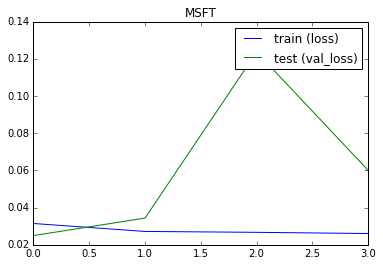

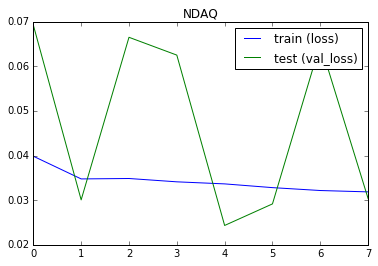

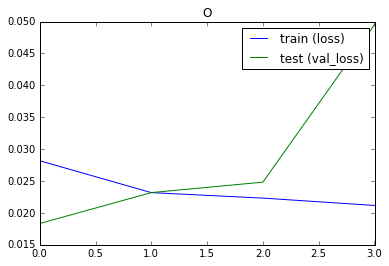

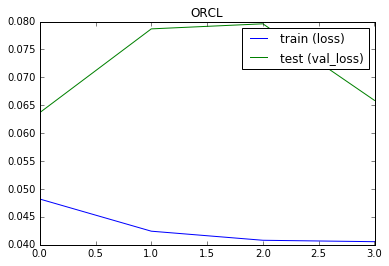

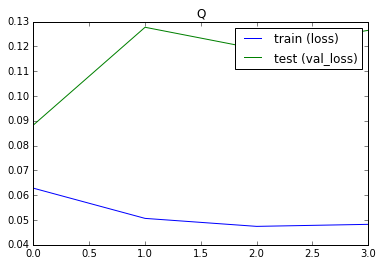

In [23]:
# Decrease n_neurons 
histories = lstm2.build_models(supervised_data_dir, models_dir, n_test, n_lags, n_features,
                               150)

for stock in sorted(histories.keys()): # plot history
    history = histories[stock]
    plt.plot(history.history['loss'], label='train (loss)')
    plt.plot(history.history['val_loss'], label='test (val_loss)')
    plt.title(stock)
    plt.legend()
    plt.show()

In [24]:
predicted_dfs3, rmse_df3 = lstm2.predict_evaluate(models_dir, 
                                                supervised_data_dir, 
                                                prediction_data_dir, 
                                                rmse_csv, 
                                                n_test, n_lags, n_features, n_forecast)
rmse_df3

../models/sp500_test/*.h5
('loading', '../models/sp500_test/MSFT.h5')
('Reading', '../data/sup_sp500_test/MSFT_supervised.csv')
Predicting...
Test RMSE: 4.702
('Writing to', '../data/prediction/sp500_test/MSFT_predicted.csv')
('loading', '../models/sp500_test/NDAQ.h5')
('Reading', '../data/sup_sp500_test/NDAQ_supervised.csv')
Predicting...
Test RMSE: 2.530
('Writing to', '../data/prediction/sp500_test/NDAQ_predicted.csv')
('loading', '../models/sp500_test/O.h5')
('Reading', '../data/sup_sp500_test/O_supervised.csv')
Predicting...
Test RMSE: 3.502
('Writing to', '../data/prediction/sp500_test/O_predicted.csv')
('loading', '../models/sp500_test/ORCL.h5')
('Reading', '../data/sup_sp500_test/ORCL_supervised.csv')
Predicting...
Test RMSE: 3.837
('Writing to', '../data/prediction/sp500_test/ORCL_predicted.csv')
('loading', '../models/sp500_test/Q.h5')
('Reading', '../data/sup_sp500_test/Q_supervised.csv')
Predicting...
Test RMSE: 9.291
('Writing to', '../data/prediction/sp500_test/Q_predicte

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,4.701617,0.062516,0.009204,0.095607,0.042196
1,NDAQ,2.530091,0.007990,0.061155,0.007740,0.023595
3,ORCL,3.837421,-0.001344,0.108223,-0.028558,0.020995
4,Q,9.291326,-0.020330,0.067273,-0.039073,0.050988
2,O,3.502310,-0.045588,0.027702,-0.047111,0.006778


In [25]:
rmse_df2

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,3.350991,0.015519,0.009204,0.008449,0.042196
2,O,2.133930,-0.012537,0.027702,-0.013073,0.006778
4,Q,8.316356,-0.002742,0.067273,-0.025767,0.050988
1,NDAQ,6.634007,-0.061582,0.061155,-0.062952,0.023595
3,ORCL,4.952261,-0.029843,0.108223,-0.066413,0.020995


In [26]:
rmse_df

,Stock Model,rsme,Day 0 predicted gain,Day 0 actual gain,Avg predicted gain,Avg actual gain
0,MSFT,6.096134,0.117156,0.009204,0.121122,0.042196
3,ORCL,2.428930,0.026866,0.108223,0.014315,0.020995
4,Q,5.704205,0.013440,0.067273,0.003833,0.050988
2,O,2.035281,0.007092,0.027702,0.000084,0.006778
1,NDAQ,3.073763,0.000035,0.061155,-0.004483,0.023595


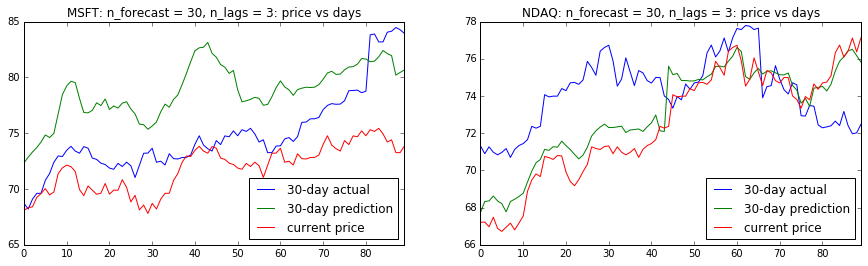

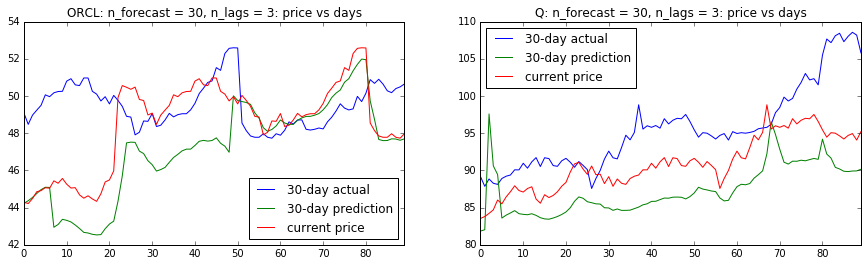

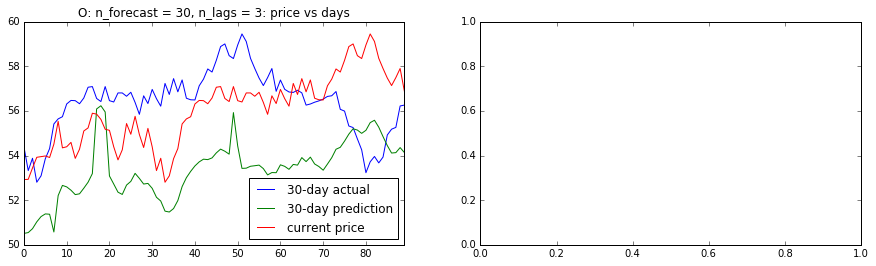

In [27]:
plot_data(rmse_df3, predicted_dfs3)

## Observation

Comparing the 3 results together, the 2nd setting yields better accuracy

In [28]:
np.abs(rmse_df3['Avg predicted gain'] - rmse_df3['Avg actual gain'])

0    0.053411
1    0.015855
3    0.049553
4    0.090061
2    0.053889
dtype: float64

In [29]:
np.abs(rmse_df2['Avg predicted gain'] - rmse_df2['Avg actual gain'])

0    0.033747
2    0.019851
4    0.076755
1    0.086547
3    0.087408
dtype: float64

In [30]:
np.abs(rmse_df['Avg predicted gain'] - rmse_df['Avg actual gain'])

0    0.078927
3    0.006680
4    0.047154
2    0.006694
1    0.028078
dtype: float64